## Introduction

In this project, I focus on evaluating the safety of neighborhoods in Pittsburgh using reported crime incident data. Public safety is a critical factor in quality of life and a major consideration for residents when choosing where to live.

The goal of this analysis is to quantify safety using available public data and turn it into a metric that can be used to compare neighborhoods fairly. This safety metric will then be used along with other submetrics fromgroupteammates to identify the best neighbor in hoodPittsbu
ely.


## The Metric: Crime-Based Safety Score

I use crime incident data from the Western Pennsylvania Regional Data Center (WPRDC). Each row in the dataset represents a single crime that occurred in the city of Pittsburgh, with attributes including the incident time and geographic coordinates (X, Y).

To calculate a safety score:
- I first filtered the dataset to include only incidents from 2022 onward.
- Then, using geographic coordinates, I assigned each crime to its respective neighborhood using a spatial join with Pittsburgh’s neighborhood boundaries.
- I counted the total number of crimes per neighborhood.
- Finally, I created a “Safety Sc counts using MinMax scaling. The result is a score between 0 and 1, where 1 means the safest and 0 means the most dangerous.

This metric provides an objective way to compare crime levels across neighborhoods.


In [1]:
import pandas as pd
crime = pd.read_csv("https://data.wprdc.org/datastore/dump/044f2016-1dfd-4ab0-bc1e-065da05fca2e")

In [2]:
crime.head()

,_id,PK,CCR,HIERARCHY,INCIDENTTIME,INCIDENTLOCATION,CLEAREDFLAG,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTHIERARCHYDESC,OFFENSES,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1,2802309,16000001.0,10,2016-01-01T00:00:00,"400 Block North Shore DR Pittsburgh, PA 15212",Y,North Shore,1,HARRASSMENT/THREAT/ATTEMPT/PHY,2702 Aggravated Assault. / 2709(a) Harassment....,2205.0,1.0,6.0,-80.012337,40.446263
1,2,2803174,16004547.0,11,2016-01-01T00:01:00,"5400 Block Carnegie ST Pittsburgh, PA 15201",N,Upper Lawrenceville,2,THEFT BY DECEPTION,3922 Theft by Deception.,1011.0,7.0,2.0,-79.950295,40.482290
2,3,2801809,16000367.0,4,2016-01-01T00:10:00,"500 Block Mt Pleasant RD Pittsburgh, PA 15214",N,Northview Heights,1,DISCHARGE OF FIREARM INTO OCC.STRUCTURE,2707.1 Discharge of a Firearm into Occupied St...,2609.0,1.0,1.0,-80.000966,40.478651
3,4,2802315,16000035.0,10,2016-01-01T00:15:00,"300 Block Wood ST Pittsburgh, PA 15222",Y,Golden Triangle/Civic Arena,2,HARRASSMENT/THREAT/ATTEMPT/PHY,2709(a)(3) Harassment No Legitimate Purpose,201.0,6.0,6.0,-80.001251,40.438918
4,5,2802312,16000024.0,4,2016-01-01T00:16:00,"500 Block Mt Pleasant RD Pittsburgh, PA 15214",N,Northview Heights,1,PROP MISSILE INTO OCC VEHICLE/OR ROADWAY,2705 Recklessy Endangering Another Person. / 3...,2609.0,1.0,1.0,-80.000966,40.478651


Extract the most recent(since 1.1.2022) 3 years' data.

In [3]:
crime['INCIDENTTIME'] = pd.to_datetime(crime['INCIDENTTIME'])
crime = crime[crime['INCIDENTTIME'] >= '2022-01-01']
crime.head()

,_id,PK,CCR,HIERARCHY,INCIDENTTIME,INCIDENTLOCATION,CLEAREDFLAG,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTHIERARCHYDESC,OFFENSES,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
266255,280537,3277328,22002393.0,29,2022-01-05 23:46:00,"1100 Block Liberty AV Pittsburgh, PA 15222",Y,Central Business District,2,RUNAWAYS - JUVENILE,029 Missing Juvenile,201.0,7.0,6.0,-79.992377,40.444163
266336,280652,3277501,22000764.0,99,2022-01-02 14:47:00,"2600 Block Palisade LANE Pittsburgh, PA 15214",Y,Perry South,1,NaN,9497 Aided Case,2615.0,NaN,NaN,NaN,NaN
266467,280783,3277798,22000195.0,10,2022-01-01 06:32:00,"2500 Block Spring ST Pittsburgh, PA 15210",Y,Arlington,3,SIMPLE ASSAULT/INJURY,2701 Simple Assault.,1603.0,7.0,6.0,-79.979488,40.453677
267618,281991,3279683,21224052.0,99,2022-01-06 11:00:00,Zone 2,Y,NaN,2,NaN,9999 Miscellaneous Report (No Crime),NaN,NaN,NaN,NaN,NaN
268314,282724,3280962,22004012.0,1,2022-01-08 16:00:00,"300 Block Reifert ST Pittsburgh, PA 15210",N,Knoxville,3,MURDER/NON-NEG/MANSLTR-KNIFE,9496 Dead on Arrival (DOA),3001.0,3.0,5.0,-79.994135,40.408396


# Data visualiazation

Read Pittsburgh neighborhoods file

In [4]:
import geopandas
import matplotlib.pyplot as plt

<Axes: >

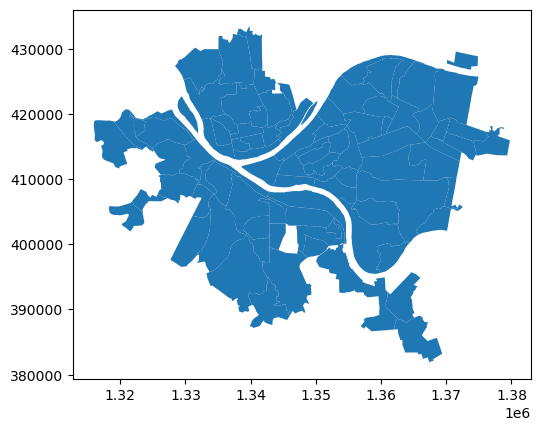

In [5]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods.plot()

### Using `Point()` to create geometry

In order to perform geographic operations like spatial joins, each crime incident must be represented as a **geographic point** — not just raw X/Y numbers.

I use `shapely.geometry.Point` to convert the latitude (`Y`) and longitude (`X`) values into **Point objects**, which GeoPandas understands as true locations on a map.

Once I have points, I can join the crime data with the Pittsburgh neighborhood map and figure out which neighborhood each crime happened in.


Convert Xs and Ys to Point data that can be read by Shapely

In [6]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(crime["X"], crime["Y"])]
gdf_crime = geopandas.GeoDataFrame(crime, geometry=geometry, crs="EPSG:4326")


Converting incidents into geometry data. Assign incident locations to neighborhoods accordingly.

In [7]:
neighborhoods = neighborhoods.to_crs("EPSG:4326")

crime_with_neighborhood = geopandas.sjoin(gdf_crime, neighborhoods, how="left", predicate="within")


Find how many incidents in each neighborhood. 

In [8]:
crime_counts = crime_with_neighborhood.groupby("hood").size().reset_index(name="CrimeCount")
crime_counts = crime_counts.sort_values("CrimeCount", ascending=False)

Those with the most incidents:

In [9]:
crime_counts.head()

,hood,CrimeCount
16,Central Business District,4446
71,South Side Flats,3244
15,Carrick,2149
67,Shadyside,1632
13,Brookline,1568


Those with the least:

In [10]:
crime_counts = crime_counts.sort_values("CrimeCount")
crime_counts.head(5)

,hood,CrimeCount
26,East Carnegie,22
66,Ridgemont,28
54,New Homestead,33
77,St. Clair,38
81,Swisshelm Park,52


Here, since the `HIERARCHY` column stands for the level of severity of incidents, I add up all the HIERARCHY levels sorted by neighborhoods. Then, we can have the total number of HIERARCHY of each neighborhood.

In [11]:
crime_weighted = crime_with_neighborhood.groupby("hood")["HIERARCHY"].sum().reset_index(name="CrimeSeverity")

crime_weighted = crime_weighted.sort_values("CrimeSeverity", ascending=False)


In [12]:
crime_weighted.head()

,hood,CrimeSeverity
16,Central Business District,178248
71,South Side Flats,133605
15,Carrick,98564
13,Brookline,78351
52,Mount Washington,73313


In [13]:
crime_weighted = crime_weighted.sort_values("CrimeSeverity", ascending=True)
crime_weighted.head()

,hood,CrimeSeverity
26,East Carnegie,1050
77,St. Clair,1491
66,Ridgemont,1520
54,New Homestead,1763
81,Swisshelm Park,2300


An interesting point is that though St.Clair has more incident numbers than New Homestead and Ridgemont, it has a lower hierarchy level, suggesting that St.Clair might be considered as a safer neighborhood. 

---

Return the number of incidents and map it.

In [14]:
# delete the duplicated column
if "CrimeSeverity" in neighborhoods.columns:
    neighborhoods = neighborhoods.drop(columns=["CrimeSeverity"])


neighborhoods = neighborhoods.merge(crime_weighted, on="hood", how="left")
neighborhoods["CrimeSeverity"] = neighborhoods["CrimeSeverity"].fillna(0)


<Axes: >

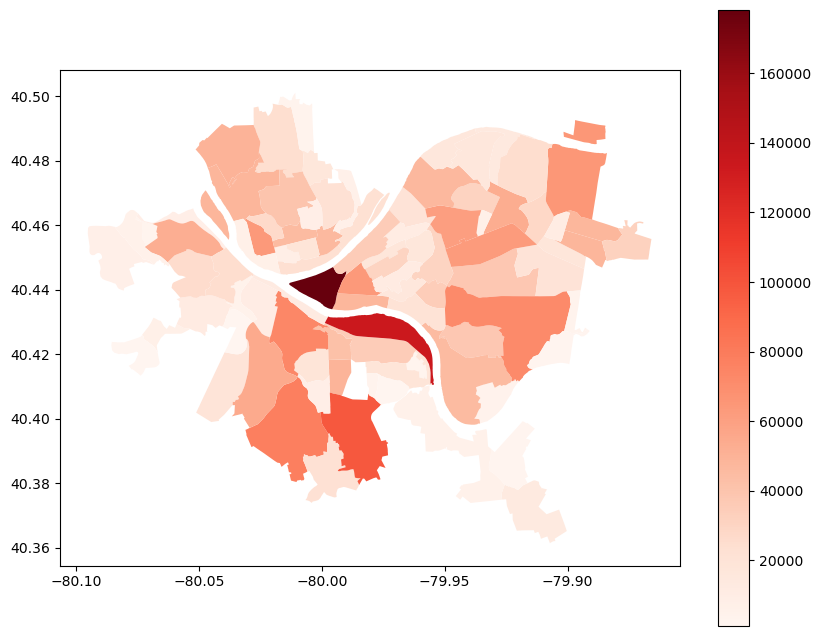

In [15]:
neighborhoods.plot(
    column="CrimeSeverity", 
    cmap="Reds", 
    legend=True, 
    figsize=(10,8)
)


### Convert Crime Count to Safety Score

In order to compare neighborhoods by safety, I transform the raw crime count into a normalized "Safety Score" between 0 and 1.

I use `MinMaxScaler` from scikit-learn to scale the number of crimes per neighborhood.


In [16]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable


Scale the number of incidents to "Safety Score". The grenner it is, the safer.

Text(0.5, 1.0, 'Neighborhood Safety Score (0=Most Dangerous, 1=Safest)')

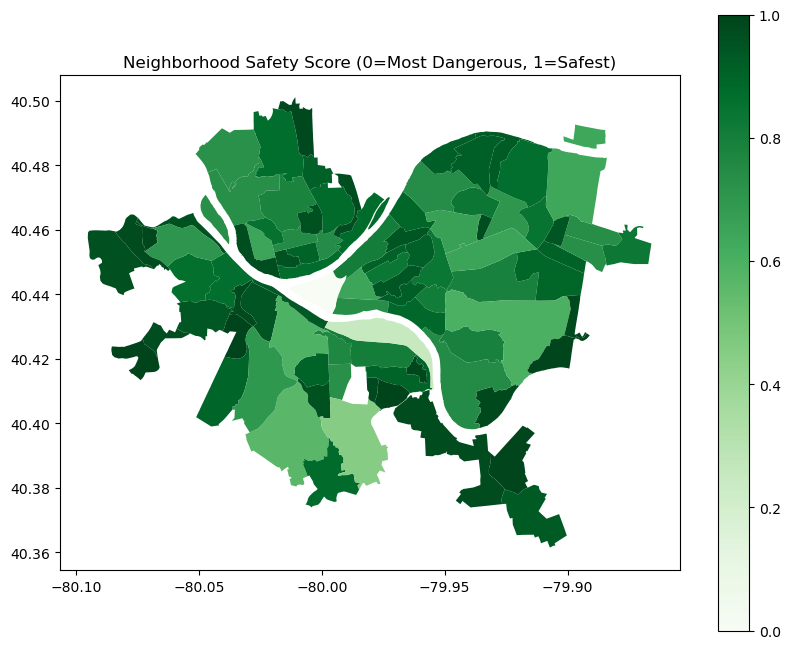

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
neighborhoods["SafetyScore"] = scaler.fit_transform(neighborhoods[["CrimeSeverity"]]) * -1 + 1

neighborhoods.plot(
    column="SafetyScore", 
    cmap="Greens", 
    legend=True, 
    figsize=(10,8))
plt.title("Neighborhood Safety Score (0=Most Dangerous, 1=Safest)")


In [18]:
neighborhoods.sort_values("SafetyScore", ascending=False)[["hood", "SafetyScore"]].head()

,hood,SafetyScore
28,East Carnegie,1.000000
73,St. Clair,0.997511
64,Ridgemont,0.997348
37,New Homestead,0.995976
82,Swisshelm Park,0.992946


In [19]:
neighborhoods.sort_values("SafetyScore", ascending=False)[["hood", "SafetyScore"]].tail()

,hood,SafetyScore
54,Mount Washington,0.592191
24,Brookline,0.563759
51,Carrick,0.449689
88,South Side Flats,0.251939
43,Central Business District,0.000000


## Conclusion

Based on crime incident data in Pittsburgh from 2022 onward, I assigned each crime to its corresponding neighborhood and calculated the total number of incidents per neighborhood. I then computed a "Safety Score" by normalizing the inverse of crime counts, where higher scores represent safer neighborhoods. 

According to this analysis, the neighborhoods with the **lowest crime rates** (and thus highest safety scores) include:
- `East Carnegie`
- `Ridgemont`
- `New Homestead`

These findings provide a data-driven snapshot of community safety across Pittsburgh. This safety submetric can now be combined with other submetrics from my groupmates to help identify the overall "best" neighborhood in the city.



# Finally
Generate a csv file that only includes the neighborhoods and their corresponding Safety Scores for merging with other group member's submetrics

In [20]:
safety_score_df = neighborhoods[["hood", "SafetyScore"]]

In [21]:
safety_score_df.head()

,hood,SafetyScore
0,Point Breeze North,0.907459
1,Squirrel Hill North,0.789264
2,Garfield,0.828988
3,Bedford Dwellings,0.907629
4,Knoxville,0.727960


In [22]:
safety_score_df.to_csv("crime_safety_scores.csv", index=False)


In [23]:
crime_with_neighborhood.to_csv("crime_with_neighborhood.csv", index=False)
